In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import os
import math
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=False, size=256):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = load_image(img_path, self.size, mask=False)
        mask = load_image(mask_path, self.size, mask=True)

        if self.augment:
            augmented = augmentation(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        # Ensure mask has shape (H, W, 1)
        if mask.ndim == 2:
            mask = np.expand_dims(mask, axis=-1)

        # Convert to torch tensors and permute to (C, H, W)
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)

        return img, mask


In [7]:
import albumentations as A

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=0.45,p=1.0)
])

In [8]:
import cv2

def load_image(path,size,mask = False):
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"Cant read image: {path}")
    image = cv2.resize(image,(size,size))
    if mask:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = image / 255.0
    return image

In [9]:
import os

def get_image_mask_paths(root_path):
    image_paths = []
    mask_paths = []
    for folder in os.listdir(root_path):
        folder_path = os.path.join(root_path,folder)
        if not os.path.isdir(folder_path):
            continue
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            is_mask = subfolder.lower() == "mask"
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)
                if is_mask:
                    mask_paths.append(file_path)
                else:
                    image_paths.append(file_path)
    image_paths.sort()
    mask_paths.sort()
    return image_paths, mask_paths

In [10]:
image_paths, mask_paths = get_image_mask_paths("/kaggle/input/ct-heart-segmentation/data/train")

In [11]:
mask_paths[0:10]

['/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-001.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-002.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-003.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-004.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-005.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-006.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-007.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-008.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-009.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/mask/1-010.png']

In [12]:
image_paths[0:10]

['/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-001.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-002.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-003.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-004.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-005.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-006.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-007.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-008.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-009.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100051/image/1-010.png']

In [13]:
from sklearn.model_selection import train_test_split
train_val_imgs, test_imgs, train_val_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size = 0.15, random_state=42
)

In [14]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    train_val_imgs, train_val_masks, test_size=0.15, random_state=42
)

In [15]:
val_imgs[0:10]

['/kaggle/input/ct-heart-segmentation/data/train/100092/image/1-102.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100094/image/1-102.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100092/image/1-054.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100093/image/1-121.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100073/image/1-022.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100091/image/1-030.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100075/image/1-020.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100053/image/1-036.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100053/image/1-030.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100093/image/1-081.png']

In [16]:
val_masks[0:10]

['/kaggle/input/ct-heart-segmentation/data/train/100092/mask/1-102.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100094/mask/1-102.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100092/mask/1-054.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100093/mask/1-121.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100073/mask/1-022.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100091/mask/1-030.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100075/mask/1-020.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100053/mask/1-036.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100053/mask/1-030.png',
 '/kaggle/input/ct-heart-segmentation/data/train/100093/mask/1-081.png']

In [17]:
train_dataset = SegmentationDataset(train_imgs, train_masks, augment= True, size=256)
val_dataset = SegmentationDataset(val_imgs,val_masks, augment=False, size = 256)
test_dataset = SegmentationDataset(test_imgs, test_masks, augment=False, size = 256)

In [30]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader= DataLoader(test_dataset, batch_size=16, shuffle=False)

In [31]:
next(iter(train_loader))[0].shape

torch.Size([16, 3, 256, 256])

In [18]:
next(iter(train_loader))[1].shape

torch.Size([16, 1, 256, 256])

In [19]:
train_loader

In [20]:
import math

def show_images_and_masks(images, masks, num_samples=8, title="Segmentation: Images and Masks"):
    """
    Display image and mask pairs in a grid.

    Args:
        images (array-like): List or array of images (H, W, C) or (C, H, W).
        masks (array-like): List or array of masks (H,W) OR (H, W,1).
        num_samples (int): Number of samples to display.
        title (str): Figure title.
    """

    num_samples = min(num_samples, len(images), len(masks))
    cols = 2
    pairs_per_row = 4
    rows = math.ceil(num_samples / pairs_per_row)

    fig, axes = plt.subplots(rows, pairs_per_row * cols, figsize=(pairs_per_row * 5, rows * 3.5))
    if rows == 1:
       axes = np.expand_dims(axes,0)

    fig.suptitle(title, fontsize = 18, color='white')
    for i in range(num_samples):
        image = images[i]
        mask = masks[i]

        #if image is torch tensor, convert to numpy
        if hasattr(image, "detach"):
            image = image.detach().cpu().numpy()
        if hasattr(mask, "detach"):
            mask = mask.detach().cpu().numpy()
        # If image is (C,H,W) convert to (H,W,C)
        if image.ndim == 3 and image.shape[0] in [1,3]:
            image =np.transpose(image, (1,2,0))
        # If mask is (1, H, W) or (H, W, 1), squeeze to (H, W)
        if mask.ndim == 3:
            mask = np.squeeze(mask)

        row = i // pairs_per_row
        col_pair = (i % pairs_per_row) * 2
        ax_img = axes[row, col_pair]
        ax_mask = axes[row, col_pair + 1]
        ax_img.imshow(image)
        ax_img.set_title("Image", fontsize = 12)
        ax_img.axis("off")
        ax_mask.imshow(mask, cmap = 'gray')
        ax_mask.set_title("Mask", fontsize=12)
        ax_mask.axis("off")

    #Hide unused axes
    total_slots = rows * pairs_per_row
    for i in range(num_samples, total_slots):
        row = i // pairs_per_row
        col_pair = (i % pairs_per_row) * 2
        axes[row, col_pair].axis("off")
        axes[row, col_pair + 1].axes("off")

    plt.tight_layout()
    plt.subplots_adjust(top = 0.88)
    plt.show()

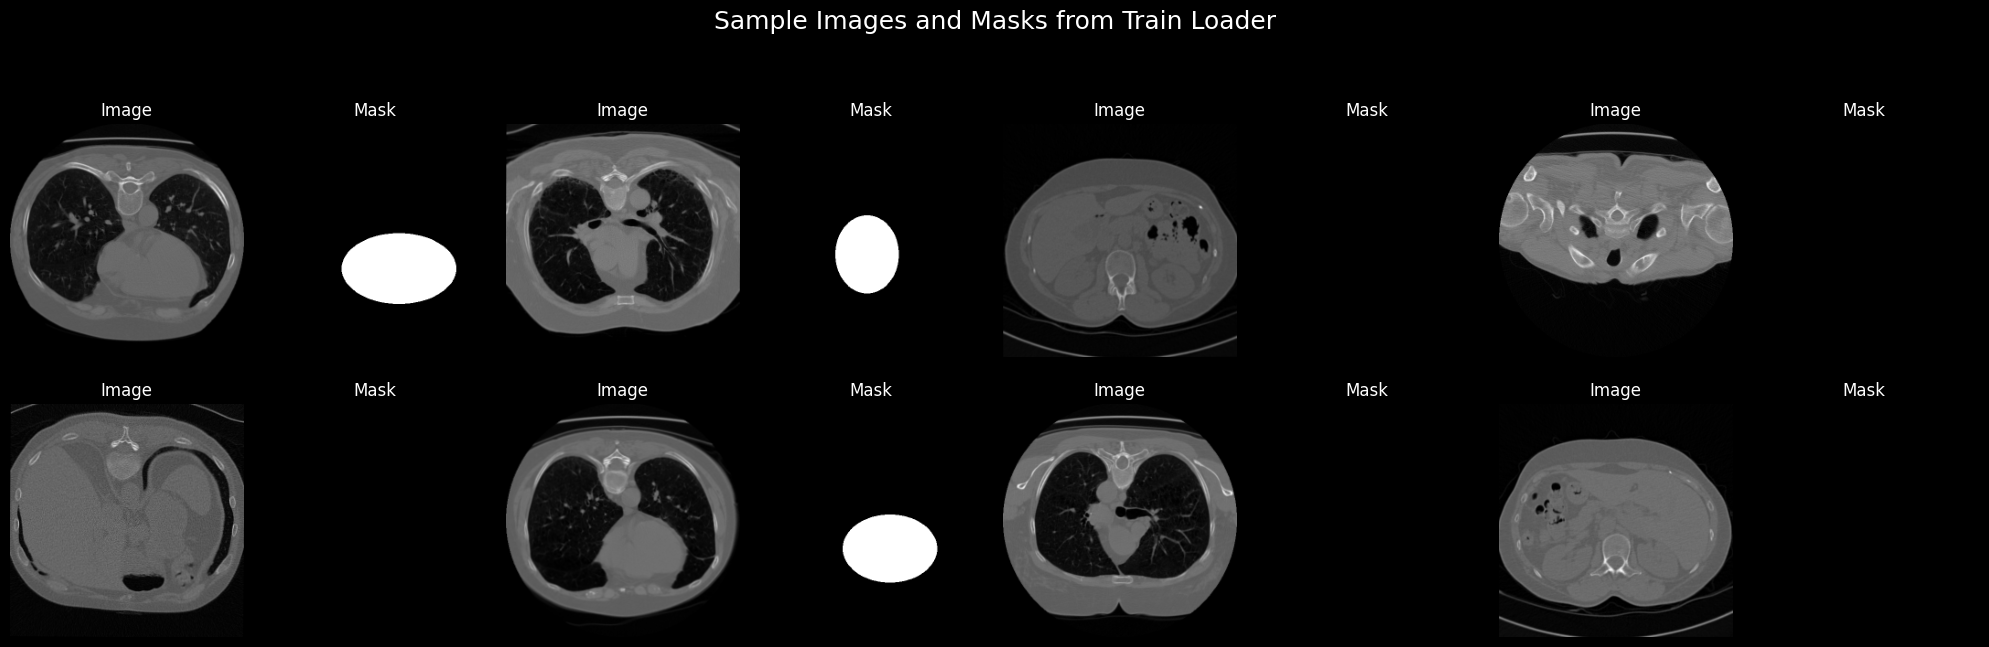

In [21]:
images, masks = next(iter(train_loader))
show_images_and_masks(images, masks, num_samples = 8, title = "Sample Images and Masks from Train Loader")

## **Model Architecture**

###   Encoder Block

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.3):
        super(EncoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_p) # Dropout layer

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x) # Apply dropout
        skip = x
        x_pooled = self.pool(x)
        return skip, x_pooled

In [31]:
# Example: input with 1 channel, output with 64 filters
encoder = EncoderBlock(in_channels=3, out_channels=64)
skip, output = encoder(torch.randn(8, 3, 256, 256))  # batch of 8 images
print(skip.shape)
print(output.shape)

torch.Size([8, 64, 256, 256])
torch.Size([8, 64, 128, 128])


### Decoder Block   

In [32]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, dropout_p=0.3):
        super(DecoderBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels + skip_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_p) # Dropout layer

    def forward(self, x, skip_features):
        x = self.up(x)
        if skip_features.shape[2:] != x.shape[2:]:
            skip_features = F.interpolate(skip_features, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_features], dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x) # Apply dropout
        return x

In [33]:
# Batch size of 1 for demonstration
x = torch.randn(1, 256, 16, 16)           # Upsampled input feature map
skip_features = torch.randn(1, 128, 32, 32)  # Skip connection feature map (larger spatial size)

In [34]:
decoder = DecoderBlock(in_channels=256, skip_channels=128, out_channels=128)
out = decoder(x, skip_features)
print(out.shape)  # Expected output: torch.Size([1, 128, 32, 32])

torch.Size([1, 128, 32, 32])


### Unet Architecture

In [35]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, dropout_p=0.3):
        super(UNet, self).__init__()
        # Encoder
        self.enc1 = EncoderBlock(in_channels, 64, dropout_p)
        self.enc2 = EncoderBlock(64, 128, dropout_p)
        self.enc3 = EncoderBlock(128, 256, dropout_p)
        self.enc4 = EncoderBlock(256, 512, dropout_p)

        # Bottleneck
        self.bottleneck_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding="same")
        self.bottleneck_bn1 = nn.BatchNorm2d(1024)
        self.bottleneck_relu1 = nn.ReLU(inplace=True)
        self.bottleneck_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bottleneck_bn2 = nn.BatchNorm2d(1024)
        self.bottleneck_relu2 = nn.ReLU(inplace=True)
        self.bottleneck_dropout = nn.Dropout(dropout_p)

        # Decoder
        self.dec1 = DecoderBlock(1024, 512, 512, dropout_p)
        self.dec2 = DecoderBlock(512, 256, 256, dropout_p)
        self.dec3 = DecoderBlock(256, 128, 128, dropout_p)
        self.dec4 = DecoderBlock(128, 64, 64, dropout_p)

        # Output layer
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        s1, x = self.enc1(x)
        s2, x = self.enc2(x)
        s3, x = self.enc3(x)
        s4, x = self.enc4(x)

        # Bottleneck
        x = self.bottleneck_relu1(self.bottleneck_bn1(self.bottleneck_conv1(x)))
        x = self.bottleneck_relu2(self.bottleneck_bn2(self.bottleneck_conv2(x)))
        x = self.bottleneck_dropout(x)

        # Decoder
        x = self.dec1(x, s4)
        x = self.dec2(x, s3)
        x = self.dec3(x, s2)
        x = self.dec4(x, s1)

        # Final output (logits)
        out = self.final_conv(x)
        return out


In [28]:
import torch.nn as nn

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            # Apply Kaiming Normal initialization for Conv2d weights
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            # Initialize bias to zero if it exists
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            # Initialize BatchNorm weights to 1 and bias to 0
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


In [29]:
model = UNet(in_channels=3, num_classes=1)
x = torch.randn(1, 3, 256, 256)  # Batch of 1 RGB image, 256x256
output = model(x)
print(output.shape)  # Should be [1, 1, 256, 256]


NameError: name 'UNet' is not defined

In [23]:
image_size = 256  # or your chosen value
# model = UNet(in_channels=3, num_classes=1)

In [31]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, num_classes=1).to(device)

In [32]:
from torchsummary import summary

summary(model, input_size=(3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
           Dropout-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
      EncoderBlock-9  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14    

In [25]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninst

In [37]:
#Checkpointing
best_val_loss = float('inf')
save_path = 'best_unet_model.pth'

#Early Stopping
patience = 5
epochs_without_improvement = 0

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
# Apply the weight initialization
# initialize_weights(model)

In [26]:
import segmentation_models_pytorch as smp
import torchmetrics

optimizer = optim.Adam(model.parameters(), lr = 1e-4)

dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

iou_metric = torchmetrics.JaccardIndex(task = "binary").to(device)
accuracy_metric = torchmetrics.Accuracy(task = "binary").to(device)


In [40]:
print(device)

cuda


In [41]:
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'val_acc': []
}

In [42]:
num_epochs = 20
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 5
save_path = 'best_model.pth'

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for images, masks in train_loader_tqdm:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_loss = train_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    iou_metric.reset()  # Reset metrics at the start of each validation epoch
    accuracy_metric.reset()
    
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
            val_loss += loss.item() * images.size(0)
            
            preds = torch.sigmoid(outputs)
            binary_preds = (preds > 0.5).int()
            
            # Update metrics with each batch
            iou_metric.update(binary_preds, masks.int())
            accuracy_metric.update(binary_preds, masks.int())

    # Compute final metrics for the epoch
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_iou = iou_metric.compute()
    epoch_acc = accuracy_metric.compute()

    # 2. Store validation metrics in the history dictionary
    history['val_loss'].append(epoch_val_loss)
    history['val_iou'].append(epoch_iou.item()) # .item() to get scalar value
    history['val_acc'].append(epoch_acc.item()) # .item() to get scalar value

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | IoU: {epoch_iou:.4f} | Acc: {epoch_acc:.4f}")

    # --- Checkpointing and Early Stopping ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved best model.")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/20 | Train Loss: 1.1559 | Val Loss: 1.0516 | IoU: 0.4769 | Acc: 0.9795
Saved best model.


Epoch 2/20 | Train Loss: 0.9531 | Val Loss: 0.9568 | IoU: 0.5334 | Acc: 0.9844
Saved best model.


Epoch 3/20 | Train Loss: 0.8473 | Val Loss: 0.8268 | IoU: 0.5968 | Acc: 0.9833
Saved best model.


Epoch 4/20 | Train Loss: 0.7539 | Val Loss: 0.8250 | IoU: 0.5142 | Acc: 0.9836
Saved best model.


Epoch 5/20 | Train Loss: 0.6713 | Val Loss: 0.6954 | IoU: 0.5982 | Acc: 0.9854
Saved best model.


Epoch 6/20 | Train Loss: 0.5856 | Val Loss: 0.5940 | IoU: 0.6830 | Acc: 0.9898
Saved best model.


Epoch 7/20 | Train Loss: 0.5023 | Val Loss: 0.5694 | IoU: 0.6405 | Acc: 0.9887
Saved best model.


Epoch 8/20 | Train Loss: 0.4402 | Val Loss: 0.5009 | IoU: 0.6645 | Acc: 0.9898
Saved best model.


Epoch 9/20 | Train Loss: 0.3815 | Val Loss: 0.4272 | IoU: 0.6659 | Acc: 0.9884
Saved best model.


Epoch 10/20 | Train Loss: 0.3333 | Val Loss: 0.6832 | IoU: 0.3907 | Acc: 0.9825


Epoch 11/20 | Train Loss: 0.2865 | Val Loss: 0.4858 | IoU: 0.5647 | Acc: 0.9870


Epoch 12/20 | Train Loss: 0.2618 | Val Loss: 0.3607 | IoU: 0.6622 | Acc: 0.9893
Saved best model.


Epoch 13/20 | Train Loss: 0.2474 | Val Loss: 0.3282 | IoU: 0.6734 | Acc: 0.9890
Saved best model.


Epoch 14/20 | Train Loss: 0.2373 | Val Loss: 0.5935 | IoU: 0.4030 | Acc: 0.9827


Epoch 15/20 | Train Loss: 0.2154 | Val Loss: 0.3492 | IoU: 0.6466 | Acc: 0.9890


Epoch 16/20 | Train Loss: 0.1933 | Val Loss: 0.4714 | IoU: 0.5061 | Acc: 0.9851


Epoch 17/20 | Train Loss: 0.1876 | Val Loss: 0.3851 | IoU: 0.5931 | Acc: 0.9880


KeyboardInterrupt: 

In [43]:
# Convert the history dictionary to a pandas DataFrame
history_df = pd.DataFrame(history)

# Display the first few rows of the DataFrame
print(history_df.head())


   train_loss  val_loss   val_iou   val_acc
0    1.155857  1.051641  0.476942  0.979545
1    0.953059  0.956796  0.533386  0.984415
2    0.847330  0.826811  0.596799  0.983271
3    0.753928  0.825036  0.514173  0.983628
4    0.671316  0.695372  0.598181  0.985436


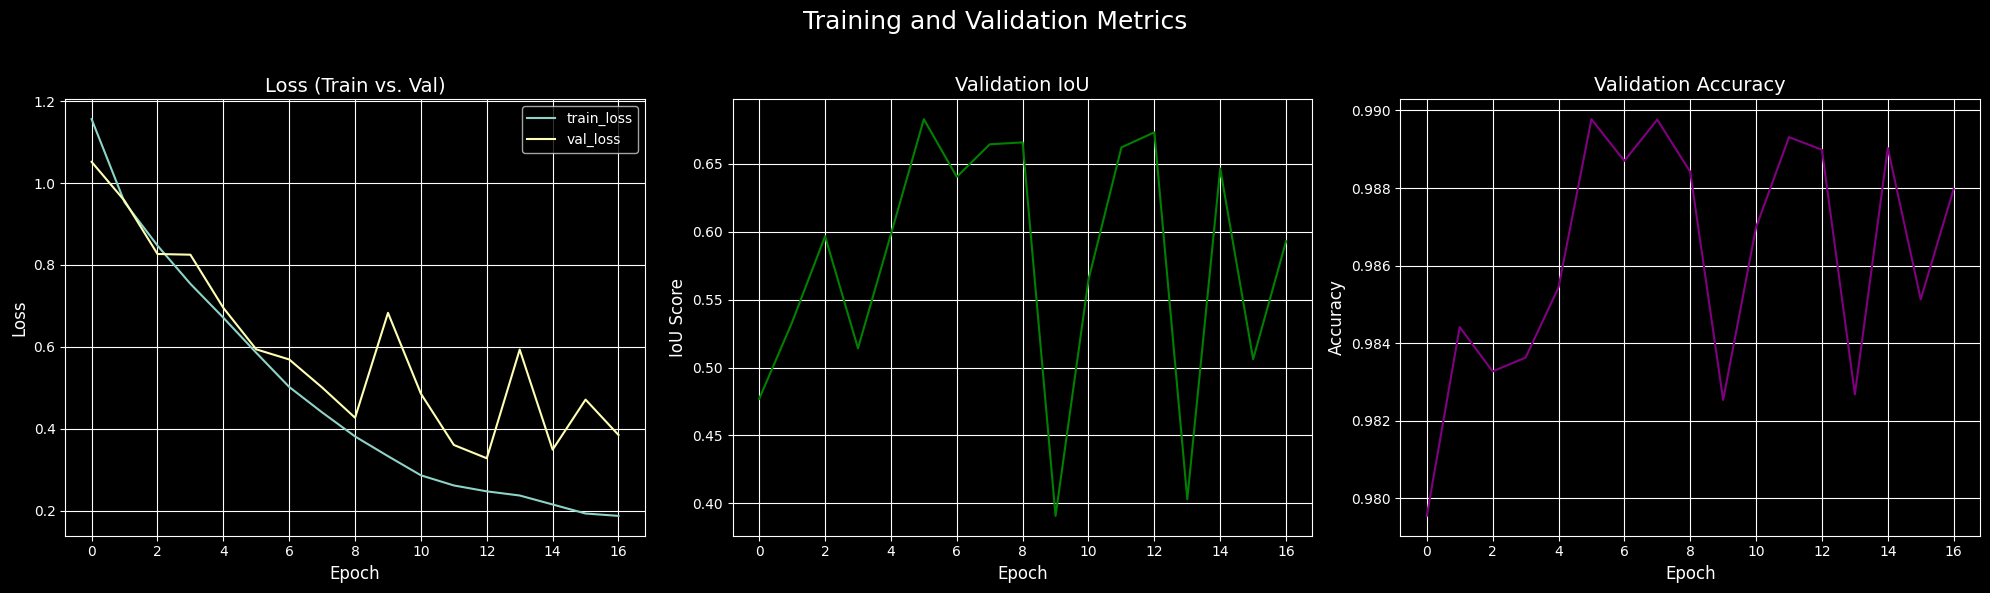

In [44]:
def plot_training_history(history):
    """
    Plots training and validation loss, IoU, and accuracy from a history dictionary.
    """
    history_df = pd.DataFrame(history)
    
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Training and Validation Metrics', fontsize=18, color='white')

    # Plot Loss
    history_df[['train_loss', 'val_loss']].plot(ax=axes[0], grid=True)
    axes[0].set_title("Loss (Train vs. Val)", fontsize=14)
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Loss", fontsize=12)

    # Plot IoU
    history_df['val_iou'].plot(ax=axes[1], color='green', grid=True)
    axes[1].set_title("Validation IoU", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("IoU Score", fontsize=12)

    # Plot Accuracy
    history_df['val_acc'].plot(ax=axes[2], color='purple', grid=True)
    axes[2].set_title("Validation Accuracy", fontsize=14)
    axes[2].set_xlabel("Epoch", fontsize=12)
    axes[2].set_ylabel("Accuracy", fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function after your training is complete
plot_training_history(history)


In [45]:
model = UNet(in_channels=3, num_classes=1, dropout_p=0.3).to(device)

# Load the saved weights from your best epoch
model_path = 'best_model.pth'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode (disables dropout, etc.)
model.eval()

UNet(
  (enc1): EncoderBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (enc2): EncoderBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [46]:
# Initialize metrics and loss
test_loss = 0.0
iou_metric.reset()
accuracy_metric.reset()

# Use torch.no_grad() to disable gradient calculations
with torch.no_grad():
    test_loader_tqdm = tqdm(test_loader, desc="Evaluating on Test Set")
    for images, masks in test_loader_tqdm:
        images, masks = images.to(device), masks.to(device)
        
        # Get model predictions (logits)
        outputs = model(images)
        
        # Calculate loss (pass raw logits)
        loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
        test_loss += loss.item() * images.size(0)
        
        # Calculate predictions for metrics
        preds = torch.sigmoid(outputs)
        binary_preds = (preds > 0.5).int()
        
        # Update metrics
        iou_metric.update(binary_preds, masks.int())
        accuracy_metric.update(binary_preds, masks.int())

# Compute final metrics over the entire test set
final_test_loss = test_loss / len(test_loader.dataset)
final_iou = iou_metric.compute()
final_accuracy = accuracy_metric.compute()


# --- 3. Print the results ---

print("\n--- Test Set Evaluation Results ---")
print(f"Test Loss: {final_test_loss:.4f}")
print(f"Test Accuracy: {final_accuracy.item():.4f}")
print(f"Test IOU Score: {final_iou.item():.4f}")

Evaluating on Test Set: 100%|██████████| 24/24 [00:17<00:00,  1.34it/s]


--- Test Set Evaluation Results ---
Test Loss: 0.2742
Test Accuracy: 0.9909
Test IOU Score: 0.7421


In [43]:
def display_predictions(model, loader, device, n_samples=4):
    """
    Displays the original image, ground truth mask, and predicted mask for a few samples.
    
    Args:
        model (torch.nn.Module): The trained PyTorch model.
        loader (DataLoader): The DataLoader for the test set.
        device (torch.device): The device (CPU or CUDA) to run the model on.
        n_samples (int): The number of samples to display.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Get a single batch of data
    images, true_masks = next(iter(loader))
    images = images.to(device)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        pred_masks = (preds > 0.5).float() # Convert probabilities to binary masks

    # Move tensors to CPU for plotting
    images_np = images.cpu().numpy()
    true_masks_np = true_masks.cpu().numpy()
    pred_masks_np = pred_masks.cpu().numpy()

    # Create the plot
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 4 * n_samples))
    fig.suptitle("Image vs. Ground Truth vs. Prediction", fontsize=18, color='white')

    for i in range(n_samples):
        # Transpose image from (C, H, W) to (H, W, C) for displaying
        img = np.transpose(images_np[i], (1, 2, 0))
        
        # Squeeze channel dimension from masks to make them (H, W)
        true_mask = np.squeeze(true_masks_np[i])
        pred_mask = np.squeeze(pred_masks_np[i])

        # Image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")

        # Ground Truth Mask
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Predicted Mask
        axes[i, 2].imshow(pred_mask, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

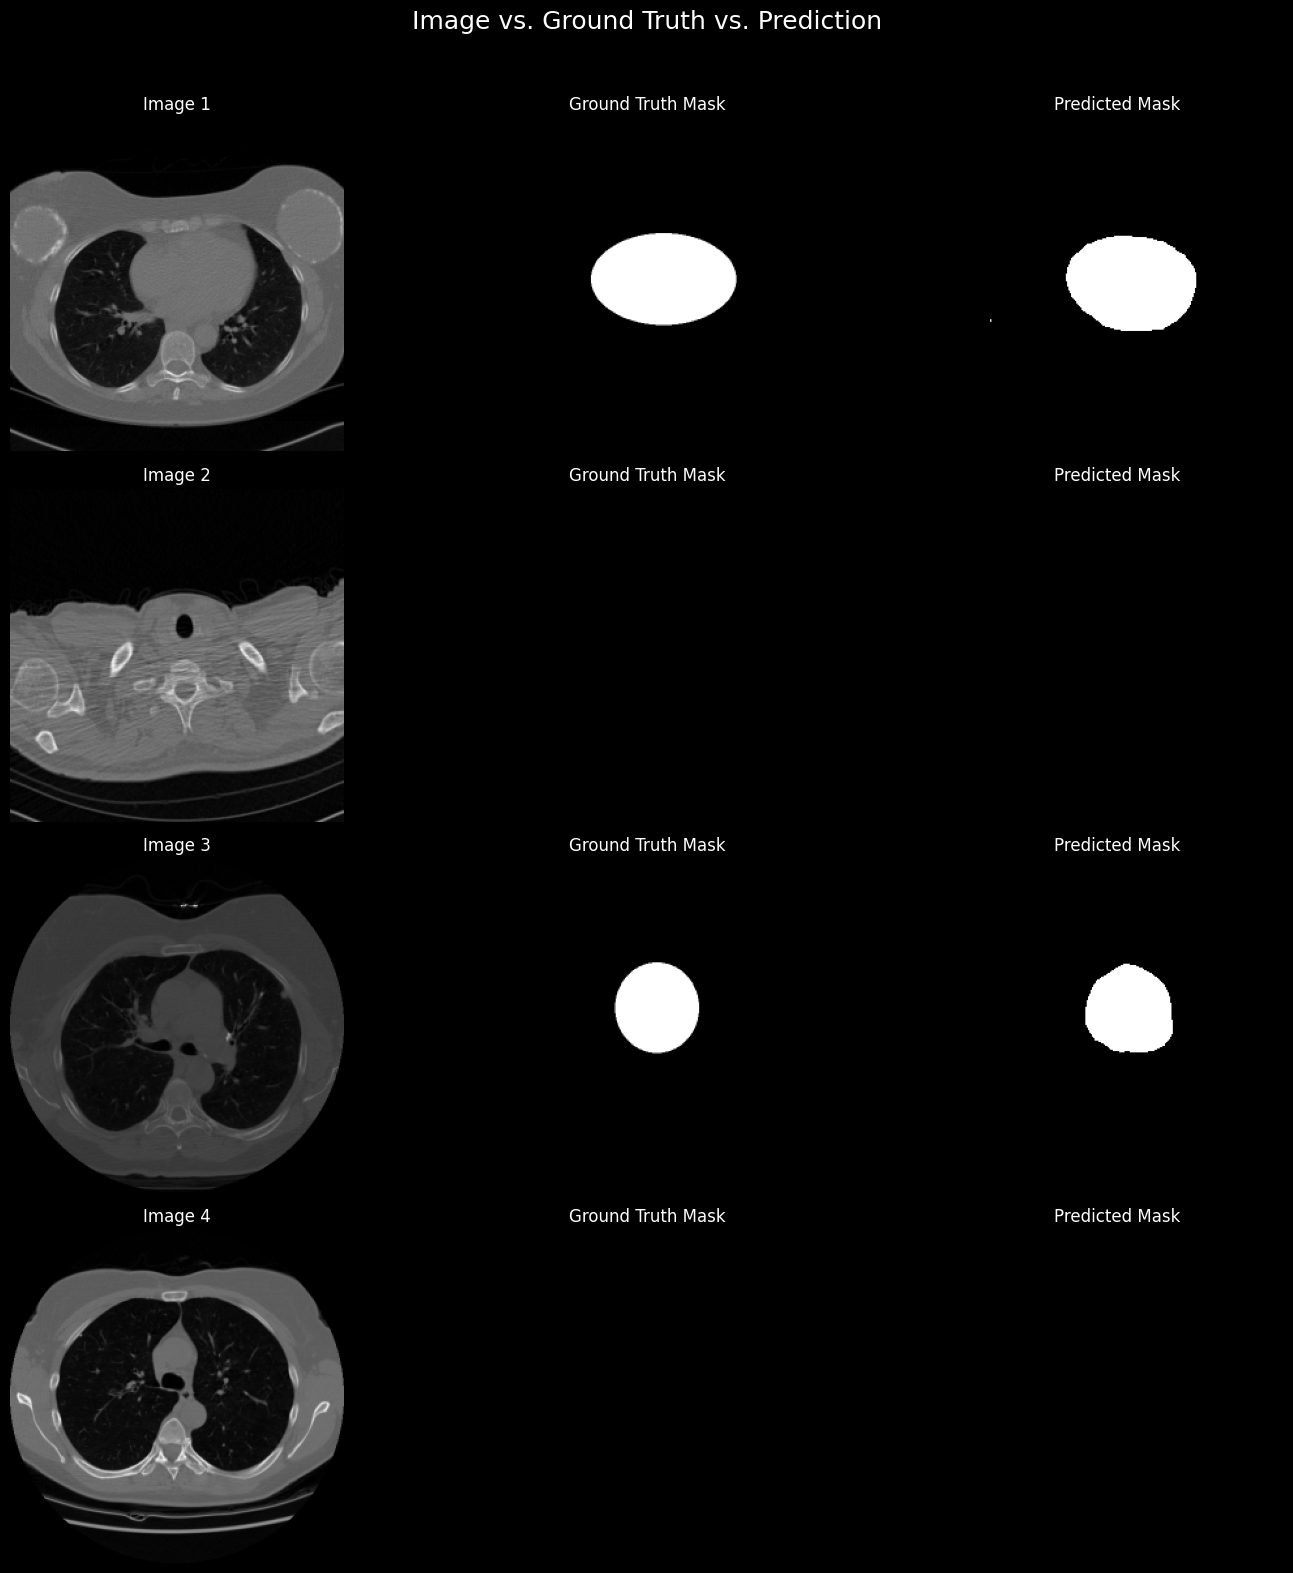

In [48]:
display_predictions(model, test_loader, device, n_samples=4)

# **Finetuning**

In [19]:
!pip install torchinfo -q

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
import torch
import segmentation_models_pytorch as smp

BACKBONE = "efficientnet-b7" 
model = smp.Unet(
    encoder_name=BACKBONE,
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

# Move the model to the desired device (e.g., GPU)
model.to(device)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_expand_conv): Identity()
        (_bn0): Identity()
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Ident

In [24]:
from torchinfo import summary

# Get the model summary using torchinfo
summary(model, input_size=(1, 3, image_size, image_size)) # (batch_size, channels, H, W)

Layer (type:depth-idx)                                  Output Shape              Param #
Unet                                                    [1, 1, 256, 256]          --
├─EfficientNetEncoder: 1-1                              [1, 3, 256, 256]          1,643,520
│    └─Conv2dStaticSamePadding: 2-1                     [1, 64, 128, 128]         1,728
│    │    └─ZeroPad2d: 3-1                              [1, 3, 257, 257]          --
│    └─BatchNorm2d: 2-2                                 [1, 64, 128, 128]         128
│    └─SiLU: 2-3                                        [1, 64, 128, 128]         --
│    └─ModuleList: 2-4                                  --                        --
│    │    └─MBConvBlock: 3-2                            [1, 32, 128, 128]         4,944
│    │    └─MBConvBlock: 3-3                            [1, 32, 128, 128]         1,992
│    │    └─MBConvBlock: 3-4                            [1, 32, 128, 128]         1,992
│    │    └─MBConvBlock: 3-5            

In [27]:
# Optimizer (Adam with weight decay )
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Loss Function (Combined BCE and Dice)
dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

# Metrics
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device)
accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)

# Learning Rate Scheduler (helps stabilize training)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=2, verbose=True)

In [28]:
# --- Initializations ---
history = {
    'train_loss': [], 'val_loss': [], 'val_iou': [], 'val_acc': []
}
num_epochs = 20
patience = 5
epochs_without_improvement = 0
best_val_loss = float('inf')
save_path = 'best_model_smp.pth' # Use a new name for the new model

In [32]:
# --- Main Training Loop ---
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    train_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    
    for images, masks in train_loader_tqdm:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        # loss = loss_fn(outputs, masks)
        loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_train_loss = train_loss / len(train_loader.dataset)
    history['train_loss'].append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    iou_metric.reset()
    accuracy_metric.reset()
    
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for images, masks in val_loader_tqdm:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # loss = loss_fn(outputs, masks)
            loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
            val_loss += loss.item() * images.size(0)
            
            # Apply sigmoid here FOR METRICS ONLY
            preds = torch.sigmoid(outputs)
            binary_preds = (preds > 0.5).int()
            
            iou_metric.update(binary_preds, masks.int())
            accuracy_metric.update(binary_preds, masks.int())

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_iou = iou_metric.compute()
    epoch_acc = accuracy_metric.compute()

    history['val_loss'].append(epoch_val_loss)
    history['val_iou'].append(epoch_iou.item())
    history['val_acc'].append(epoch_acc.item())

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | IoU: {epoch_iou:.4f} | Acc: {epoch_acc:.4f}")

    scheduler.step(epoch_val_loss)

    # --- Checkpointing and Early Stopping ---
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"Saved best model to {save_path}")
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/20 | Train Loss: 1.4427 | Val Loss: 1.4216 | IoU: 0.3662 | Acc: 0.9532
Saved best model to best_model_smp.pth


Epoch 2/20 | Train Loss: 1.0584 | Val Loss: 1.0276 | IoU: 0.7828 | Acc: 0.9927
Saved best model to best_model_smp.pth


Epoch 3/20 | Train Loss: 0.8744 | Val Loss: 0.8011 | IoU: 0.7612 | Acc: 0.9916
Saved best model to best_model_smp.pth


Epoch 4/20 | Train Loss: 0.6860 | Val Loss: 0.6360 | IoU: 0.7541 | Acc: 0.9911
Saved best model to best_model_smp.pth


Epoch 5/20 | Train Loss: 0.5133 | Val Loss: 0.4972 | IoU: 0.7698 | Acc: 0.9918
Saved best model to best_model_smp.pth


Epoch 6/20 | Train Loss: 0.3859 | Val Loss: 0.3696 | IoU: 0.7899 | Acc: 0.9926
Saved best model to best_model_smp.pth


Epoch 7/20 | Train Loss: 0.2930 | Val Loss: 0.3090 | IoU: 0.8108 | Acc: 0.9940
Saved best model to best_model_smp.pth


Epoch 8/20 | Train Loss: 0.2229 | Val Loss: 0.2273 | IoU: 0.8332 | Acc: 0.9945
Saved best model to best_model_smp.pth


Epoch 9/20 | Train Loss: 0.1770 | Val Loss: 0.2036 | IoU: 0.8320 | Acc: 0.9945
Saved best model to best_model_smp.pth


Epoch 10/20 | Train Loss: 0.1503 | Val Loss: 0.1828 | IoU: 0.8435 | Acc: 0.9950
Saved best model to best_model_smp.pth


Epoch 11/20 | Train Loss: 0.1331 | Val Loss: 0.1574 | IoU: 0.8551 | Acc: 0.9955
Saved best model to best_model_smp.pth


Epoch 12/20 | Train Loss: 0.1198 | Val Loss: 0.1617 | IoU: 0.8444 | Acc: 0.9953


Epoch 13/20 | Train Loss: 0.1066 | Val Loss: 0.1452 | IoU: 0.8445 | Acc: 0.9951
Saved best model to best_model_smp.pth


Epoch 14/20 | Train Loss: 0.0956 | Val Loss: 0.1238 | IoU: 0.8656 | Acc: 0.9958
Saved best model to best_model_smp.pth


Epoch 15/20 | Train Loss: 0.0875 | Val Loss: 0.1403 | IoU: 0.8394 | Acc: 0.9949


Epoch 16/20 | Train Loss: 0.0914 | Val Loss: 0.1278 | IoU: 0.8596 | Acc: 0.9957


Epoch 17/20 | Train Loss: 0.0845 | Val Loss: 0.1170 | IoU: 0.8657 | Acc: 0.9959
Saved best model to best_model_smp.pth


Epoch 18/20 | Train Loss: 0.0873 | Val Loss: 0.1245 | IoU: 0.8466 | Acc: 0.9951


Epoch 19/20 | Train Loss: 0.0763 | Val Loss: 0.0961 | IoU: 0.8874 | Acc: 0.9966
Saved best model to best_model_smp.pth


Epoch 20/20 | Train Loss: 0.0735 | Val Loss: 0.0974 | IoU: 0.8827 | Acc: 0.9964


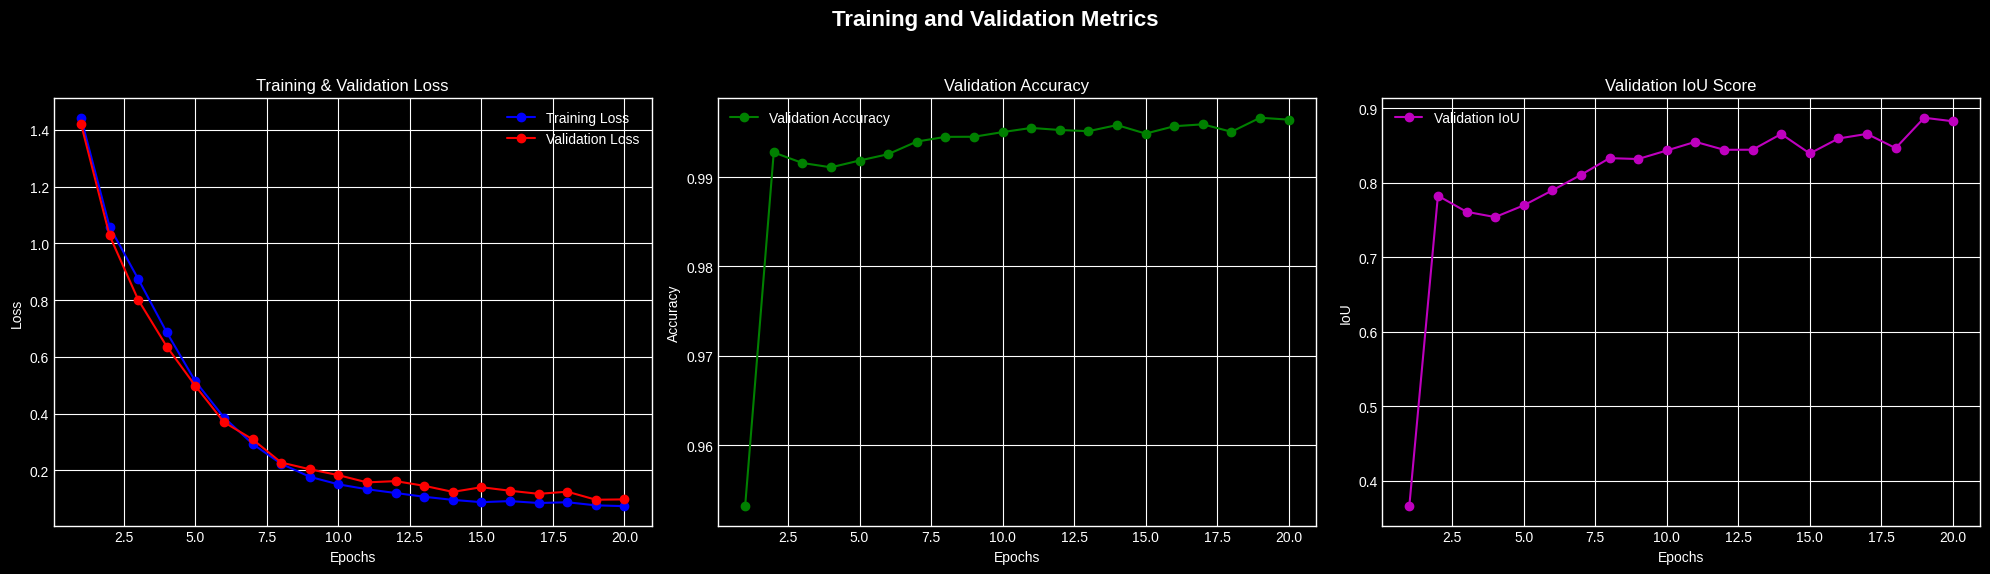

In [35]:
import matplotlib.pyplot as plt

# This code assumes your training loop has completed and the 'history' dictionary is populated.
# history = {'train_loss': [...], 'val_loss': [...], 'val_iou': [...], 'val_acc': [...]}

# Determine the number of epochs the training actually ran for
num_epochs_trained = len(history['train_loss'])
epochs = range(1, num_epochs_trained + 1)

# Create a figure with 3 subplots in a single row
# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('dark_background')
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Training and Validation Metrics', fontsize=16, weight='bold')

# --- Plot 1: Loss ---
ax[0].plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
ax[0].plot(epochs, history['val_loss'], 'r-o', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# --- Plot 2: Accuracy ---
# Note: Your loop only tracks validation accuracy, which is standard.
ax[1].plot(epochs, history['val_acc'], 'g-o', label='Validation Accuracy')
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# --- Plot 3: IoU Score ---
# Note: Your loop only tracks validation IoU.
ax[2].plot(epochs, history['val_iou'], 'm-o', label='Validation IoU')
ax[2].set_title('Validation IoU Score')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('IoU')
ax[2].legend()

# Display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path = 'best_model_smp.pth' # Path to your saved PyTorch model weights
BACKBONE = "efficientnet-b7"

# Step 1: Create an instance of the same model architecture used for training.
model = smp.Unet(
    encoder_name=BACKBONE,
    encoder_weights="imagenet",
    in_channels=3,
    classes=1, # For binary segmentation with BCE+Dice loss
    activation=None # Output raw logits, sigmoid is applied in loss/metrics
)

In [37]:
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

dice_loss = smp.losses.DiceLoss(mode="binary")
bce_loss = smp.losses.SoftBCEWithLogitsLoss()

In [39]:
accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)
iou_metric = torchmetrics.JaccardIndex(task="binary").to(device) # Jaccard Index is IoU

In [40]:
model.eval()

# Initialize accumulators for loss and reset metrics
total_test_loss = 0.0
accuracy_metric.reset()
iou_metric.reset()

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Loop through the test dataloader with a progress bar
    for images, masks in tqdm(test_loader, desc="Evaluating on Test Set"):
        # Move data to the configured device
        images, masks = images.to(device), masks.to(device)

        # Forward pass to get model predictions (logits)
        outputs = model(images)

        # Calculate the loss for the current batch
        loss = dice_loss(outputs, masks) + bce_loss(outputs, masks)
        total_test_loss += loss.item() * images.size(0)

        # To calculate metrics, convert logits to binary predictions
        preds = torch.sigmoid(outputs)
        binary_preds = (preds > 0.5).int()
        
        # Update metrics with the predictions and ground truth masks
        accuracy_metric.update(binary_preds, masks.int())
        iou_metric.update(binary_preds, masks.int())

# Calculate final average loss and compute final metrics
avg_test_loss = total_test_loss / len(test_loader.dataset)
test_accuracy = accuracy_metric.compute()
test_iou = iou_metric.compute()


Evaluating on Test Set: 100%|██████████| 24/24 [00:16<00:00,  1.44it/s]


In [41]:
# Print the results in the desired format
print("\n--- Test Set Evaluation Results ---")
results = [avg_test_loss, test_accuracy.item(), test_iou.item()]
for name, value in zip(["Test Loss", "Test Accuracy", "Test IOU Score"], results):
    print(f"{name}: {value:.4f}")


--- Test Set Evaluation Results ---
Test Loss: 0.0943
Test Accuracy: 0.9962
Test IOU Score: 0.8858


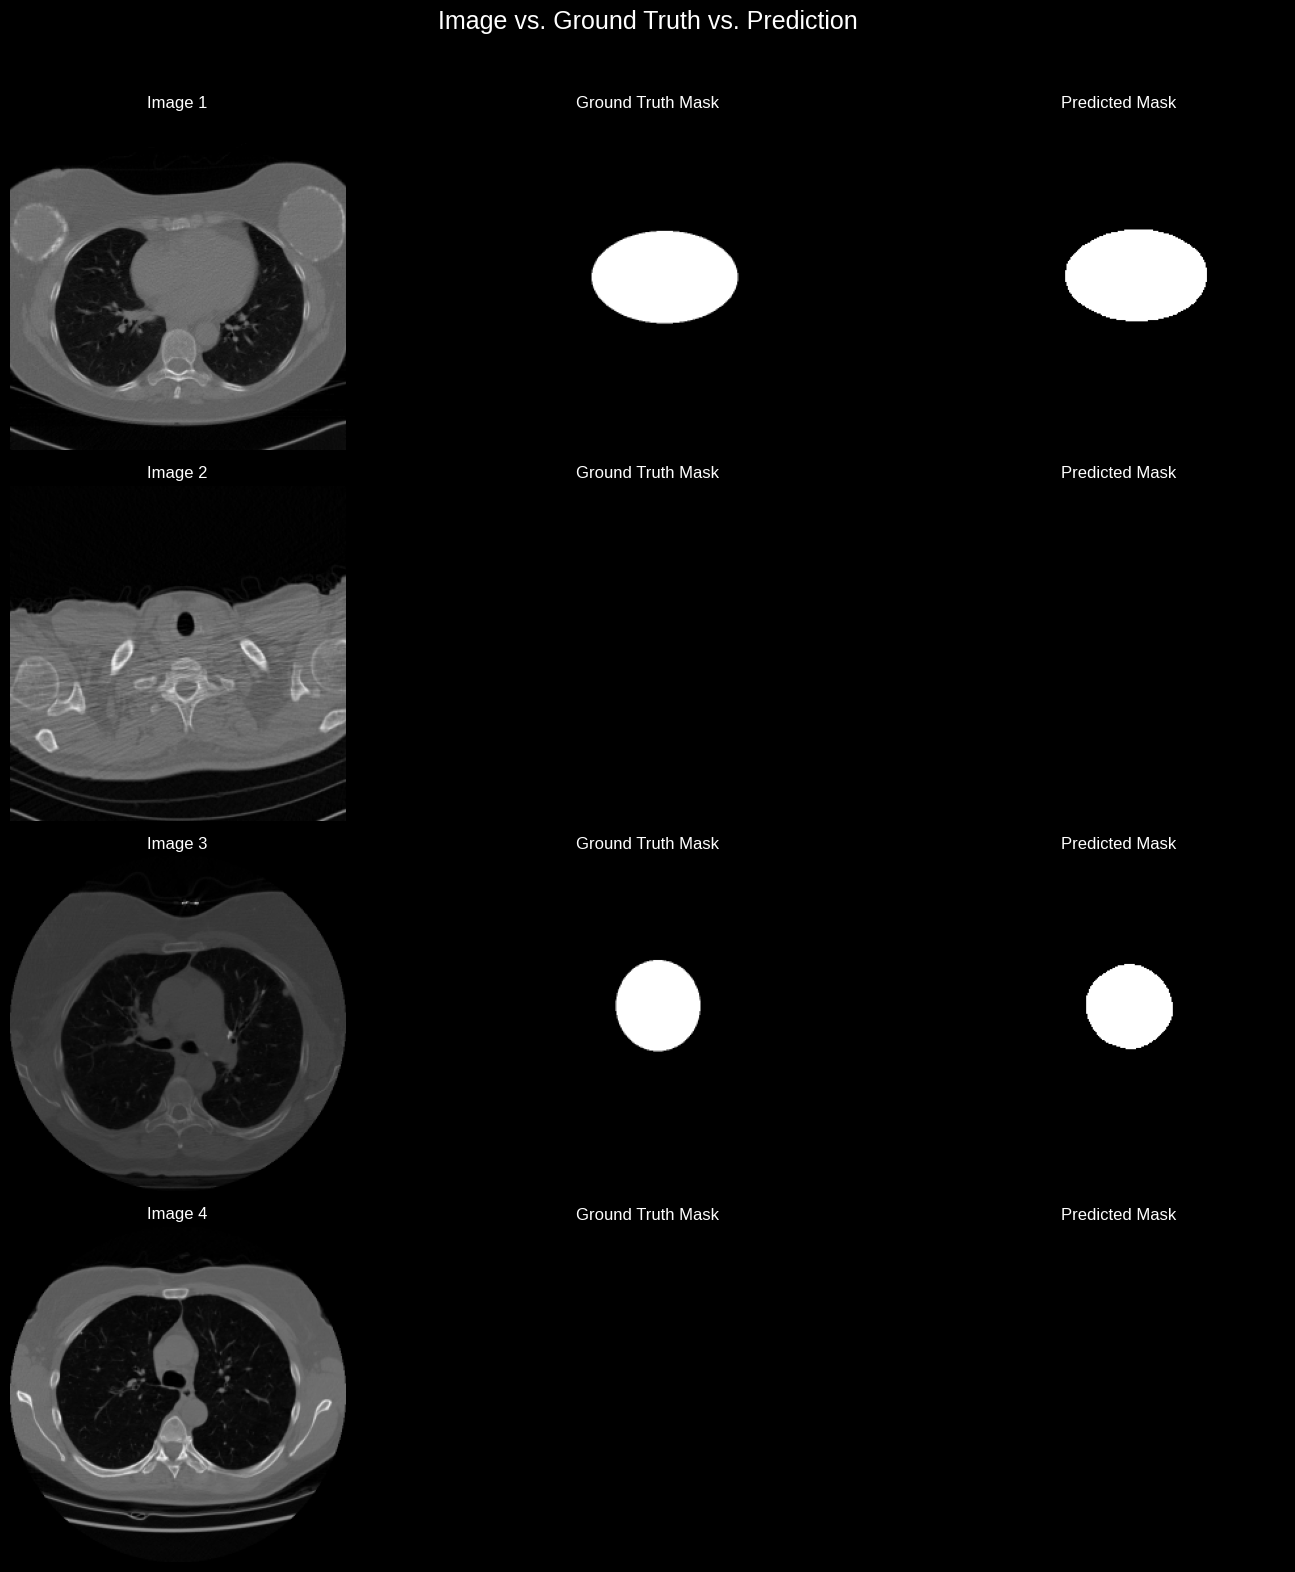

In [44]:
display_predictions(model, test_loader, device, n_samples=4)